### Описание проекта
Вы работаете в стартапе, который продаёт продукты питания. Нужно разобраться, как ведут себя пользователи вашего мобильного приложения. Для этого необходимо изучить воронку продаж и узнать, как пользователи доходят до покупки; исследовать, сколько пользователей доходит до покупки, а сколько — «застревает» на предыдущих шагах и на каких именно.

После этого необходимо исследовать результаты A/B-эксперимента. Дизайнеры захотели поменять шрифты во всём приложении, а менеджеры испугались, что пользователям будет непривычно. Договорились принять решение по результатам A/B-теста. Для него пользователей разбили на 3 группы: 2 контрольные со старыми шрифтами и одну экспериментальную — с новыми. Необходимо выяснить, какой шрифт лучше.

### Описание данных
Каждая запись в логе — это действие пользователя, или событие.
- EventName — название события;
- DeviceIDHash — уникальный идентификатор пользователя;
- EventTimestamp — время события;
- ExpId — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.

### План работы
1. **[Экспорт файла и изучение общей информации](#start)**


2. **[Подготовка данных](#prep)**
    - [Форматирование столбцов](#format)
    - [Обработка дубликатов](#dupl)
    - [Преобразование дат](#date)
    
    
3. **[Изучение данных](#eda)**
     - [Сколько всего событий в логе?](#events)
     - [Сколько всего пользователей в логе?](#users)
     - [Сколько в среднем событий приходится на пользователя?](#mean)
     - [Максимальная и минимальная дата](#minmax)
     - [Исследование данных по датам на графиках](#hist)
     - [Фильтрация событий и пользователей](#filt)
     - [Распределение пользователей по группам](#groups)
     
     
4. **[Изучение воронки событий](#funnel)**
    - [Изучение событий в логах, сортировка по частоте](#ev)
    - [Изучение поведения пользователей в логах, рассчет доли пользователей](#ratio)
    - [На каком шаге теряете больше всего пользователей?](#step)
    - [Какая доля пользователей доходит от первого события до оплаты?](#pay)
    
    
5. **[Изучение результатов эксперимента](#exp)**
    - [Сколько пользователей в каждой экспериментальной группе?](#us)
    - [Формирование общей таблицы по всем группам и исследование конверсии](#cr)
    - [Проверка 246 и 247 групп на эквивалентность](#aa)
    - [Проверка различий между группами 246 и 248, 247 и 248](#a12b)
    - [Проверка статистичеаких различий между группами A и B](#ab)
    
    
6. **[Общий вывод](#result)**

## 1. Загрузка данных и изучение общей информации

In [42]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
import numpy as np
import scipy.stats as st
from statsmodels.stats.proportion import proportions_ztest
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import plotly.express as px
import plotly.graph_objects as go
plt.rcParams['figure.figsize'] = (15,6)
import plotly.io as pio
pio.renderers.default = "svg"

<a id='start'></a>

In [43]:
df = pd.read_csv('logs_exp.csv')
df.drop('Unnamed: 0', axis=1, inplace=True)

In [44]:
df.head()

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


### Вывод:

Перед нами датасет с логами о событиях и действиях пользователей. В данных нет пропусков, все столбцы имеют правильный тип данных. Столбец timestamp необходимо привести к типу datetime, чтобы получить дату в привычном формате. Сами названия столбцов так же необходимо отформатировать.

## 2. Подготовка данных
<a id='prep'></a>

Отформатируем названия столбцов:
<a id='format'></a>

In [46]:
df.columns = ['event_name', 'device_id_hash', 'ev_timest', 'exp_id']

Проверим данные на наличие дубликатов:
<a id='dupl'></a>

In [47]:
print(f'В данных {df.duplicated().sum()} дублированных записей')

В данных 413 дублированных записей


Очистим данные от дубликатов:

In [48]:
df.drop_duplicates(inplace=True)

Перевод времени из формата UTC в календарный формат, также отдельно выделим столбец с датой:
<a id='date'></a>

In [49]:
df['exact_date']= pd.to_datetime(df['ev_timest'], unit='s')
df['date'] = df['exact_date'].astype('datetime64[D]')

### Вывод:

На этом этапе были отформатированы названия столбцов, данные очищены от дубликатов, столбец timestamp переведен в календарный формат, отдельно выделен столбец с датой.

<a id='eda'></a>
## 3.  Исследование данных

Ответим на следующие вопросы:

<a id='events'></a>
- Сколько всего событий в логе?

In [50]:
print(f'Всего в логе {df.shape[0]} событий')

Всего в логе 243713 событий


<a id='users'></a>
- Сколько всего пользователей в логе?

In [51]:
print('Всего {} пользователей в логе'.format(df['device_id_hash'].nunique()))

Всего 7551 пользователей в логе


<a id='mean'></a>
- Сколько в среднем событий приходится на пользователя?

In [52]:
mean_ev_per_user = int(round(df.groupby('device_id_hash')['device_id_hash'].count().mean()))
print(f'Среднее число событий на пользователя: {mean_ev_per_user}')

Среднее число событий на пользователя: 32


<a id='minmax'></a>
- Определим, данными за какой период мы располагаем:

In [53]:
print('Минимальная дата:', str(df['exact_date'].min()))
print('Максимальная дата:', str(df['exact_date'].max()))

Минимальная дата: 2019-07-25 04:43:36
Максимальная дата: 2019-08-07 21:15:17


Построим столбчатую диаграмму и гистограмму распределения данных в логах по датам:
<a id='hist'></a>

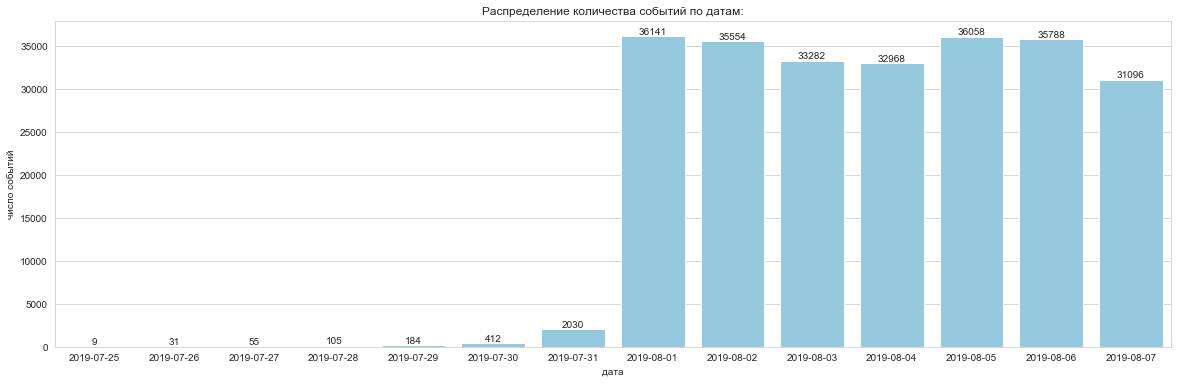

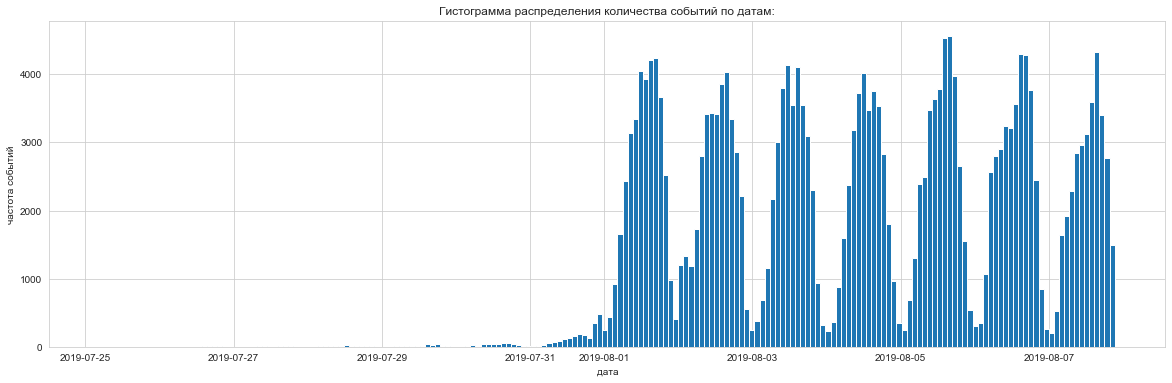

In [54]:
plt.figure(figsize=(20, 6))
freq = df['date'].value_counts().sort_index().reset_index()
ax=sns.barplot(data=freq , x= freq['index'].astype(str), y=freq['date'], color='skyblue')
for i in ax.patches:
    ax.annotate('{:.0f}'.format(i.get_height()), (i.get_x() + 0.4, i.get_height() + 0.1), ha="center", va='bottom')
plt.ylabel('число событий')
plt.xlabel('дата')
plt.title('Распределение количества событий по датам:')
plt.show()
plt.figure(figsize=(20, 6))
df['exact_date'].hist(bins=200)
plt.ylabel('частота событий')
plt.xlabel('дата')
plt.title('Гистограмма распределения количества событий по датам:')
plt.show()

На двух графиках видно, что большая часть записей приходится на даты c 1го по 7е августа. Удалим все записи из  датасета до 1го августа, посчитаем количество удаленных данных:
<a id='filt'></a>

In [55]:
dates_to_filt = list(freq[freq['date'] < freq['date'].quantile(.50)]['index'])
print(f'Будут удалены данные с {(min(dates_to_filt)).strftime("%Y-%m-%d")} по \
{(max(dates_to_filt).strftime("%Y-%m-%d"))} включительно')

Будут удалены данные с 2019-07-25 по 2019-07-31 включительно


Посмотрим, сколько пользователей и событий было потеряно при фильтрации старых событий:


In [56]:
print('Число отброшенных данных:', df[df['date'].isin(dates_to_filt)].shape[0])
print('Доля отброшенных данных от общего числа в датафрейме: {:.1%}'\
      .format(df[df['date'].isin(dates_to_filt)].shape[0] / df.shape[0]))

Число отброшенных данных: 2826
Доля отброшенных данных от общего числа в датафрейме: 1.2%


In [57]:
new_users = df[~df['date'].isin(dates_to_filt)]['device_id_hash'].nunique()
deleted_users = df['device_id_hash'].nunique() - new_users
print('Число потерянных пользователей:',  deleted_users)

Число потерянных пользователей: 17


Перед фильтацией добавим столбец с объедененными контрольными группами:

In [58]:
for i in df['exp_id'].unique():
    if i == 248:
        df.loc[df['exp_id'] == i, 'groups'] = 'B'
    else:
        df.loc[df['exp_id'] == i, 'groups'] = 'A'

Отфильтруем данные и посмотрим, как распределены пользователи из трех групп:
<a id='groups'></a>

In [59]:
def formatter(x):
    return '{:.1%}'.format(x)
filt_df = df[~df['date'].isin(dates_to_filt)] 
groups = filt_df.groupby('exp_id').agg({'device_id_hash':'nunique'})\
    .assign(ratio = lambda x: (x['device_id_hash'] / x['device_id_hash'].sum()).apply(lambda x: '{:.2%}'.format(x)))
groups.index.name, groups.columns = 'group', ['count', 'ratio']
groups

,count,ratio
group,,
246,2484,32.97%
247,2513,33.36%
248,2537,33.67%


Пользователи присутствуют во всех трех группах, после фильтрации количество пользователей в трех группах различается в пределах 1%

### Вывод:

На этом этапе исследовали число событий в логе (243713), число пользователей в логе (7551) и среднее число событий на пользователя (32). Также определили, что располагаем данными за период с 1-го по 7е августа. Данные отфильтровали, было отброшено 1.2% значений датасета, 17 уникальных пользователей. После фильтрации количество пользователей в трех группах различается не более, чем на 1%.

## 4. Изучение воронки событий
<a id='funnel'></a>

<a id='ev'></a>
Посмотрим, какие события есть в логах, как часто они встречаются. Отсортируем события по частоте:

In [60]:
def events_df(query):
    ev = query['event_name'].value_counts().reset_index()\
    .merge(query['event_name'].value_counts(normalize=True).reset_index(), on='index')
    ev.columns = ['event_name', 'count', 'ratio']
    ev = ev.assign(ratio = lambda x: x['ratio'].apply(formatter),
                   cr_initial = lambda x: x['count'].apply(lambda x: '{:.1%}'.format(x / ev['count'].max())),
                    cr_prev = lambda x: (x['count'].pct_change()+1).fillna(value=1).apply(formatter))

    return ev
display(events_df(filt_df).set_index('event_name'))

,count,ratio,cr_initial,cr_prev
event_name,,,,
MainScreenAppear,117328,48.7%,100.0%,100.0%
OffersScreenAppear,46333,19.2%,39.5%,39.5%
CartScreenAppear,42303,17.6%,36.1%,91.3%
PaymentScreenSuccessful,33918,14.1%,28.9%,80.2%
Tutorial,1005,0.4%,0.9%,3.0%


- count - число записей на каждое событие
- ratio - процентное соотношение количество записей на каждом событии
- cr_initial - конверсия числа событий на каждом этапе от MainScreenAppear
- cr_prev - конверсия числа записей на каждом шаге от предыдущего шага

Исходя из полученных данных, по числу действий можно установить порядок событий: MainScreenAppear -> OffersScreenAppear -> CartScreenAppear -> PaymentScreenSuccessful. 14% всех событий - успешная оплата, это 28.9% конверсии от общего числа событий. Также можно отметить, что события не выстраиваются в последовательную цепочку, поскольку наличие Tutorial последним событием нелогично. Скорее всего небольшое число пользователей на одном из первых этапов решает воспользоваться обучением. Отфильтруем датасет по этому событию и визуализируем данные:

In [61]:
display(events_df(filt_df.query('event_name not in "Tutorial"')).set_index('event_name'))

,count,ratio,cr_initial,cr_prev
event_name,,,,
MainScreenAppear,117328,48.9%,100.0%,100.0%
OffersScreenAppear,46333,19.3%,39.5%,39.5%
CartScreenAppear,42303,17.6%,36.1%,91.3%
PaymentScreenSuccessful,33918,14.1%,28.9%,80.2%


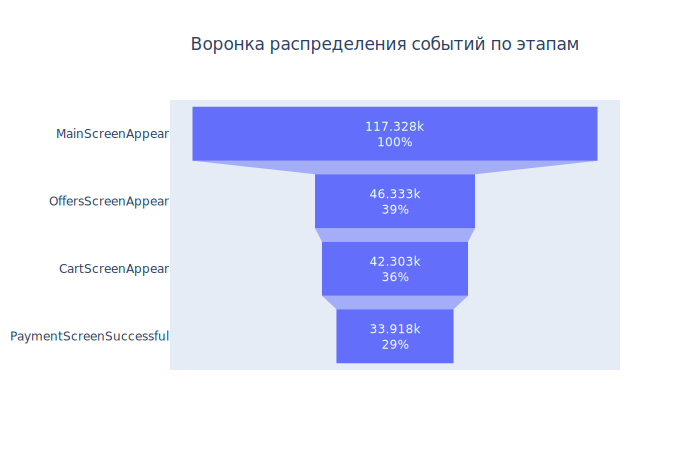

In [62]:
def funnel(frame, title):
    data = frame
    fig = go.Figure(go.Funnel(
         x=data['count'],
         y=data['event_name'], textinfo = "value+percent initial"))
    fig.update_layout(
        title={
            'text': title,
            'x':0.55})
    fig.show()
funnel(events_df(filt_df.query('event_name not in "Tutorial"')),  "Воронка распределения событий по этапам")

Посчитаем, сколько пользователей совершали каждое из этих событий. Отсортируем события по числу пользователей и посчитаем долю пользователей, которые хоть раз совершали событие:
<a id='ratio'></a>

In [63]:
def un_users(query):
    uniq_users = query.groupby('event_name').agg({'device_id_hash':'nunique'})\
    .sort_values(by='device_id_hash',ascending=False)\
    .assign(cr_initial = lambda x: (x['device_id_hash'] / x['device_id_hash'].max()).map(formatter),
            cr_prev = lambda x: (x['device_id_hash'].pct_change()+1).fillna(value=1).apply(formatter))\
    .rename(columns={'device_id_hash': 'count'})
    return uniq_users

In [64]:
un_users(filt_df).assign(cr_total = lambda x: (x['count'] / filt_df['device_id_hash'].nunique()).map(formatter))

,count,cr_initial,cr_prev,cr_total
event_name,,,,
MainScreenAppear,7419,100.0%,100.0%,98.5%
OffersScreenAppear,4593,61.9%,61.9%,61.0%
CartScreenAppear,3734,50.3%,81.3%,49.6%
PaymentScreenSuccessful,3539,47.7%,94.8%,47.0%
Tutorial,840,11.3%,23.7%,11.1%


- count - число пользователей на каждом событии
- cr_initial - конверсия числа пользователей на каждом этапе от MainScreenAppear
- cr_prev - конверсия числа пользователей на каждом шаге от предыдущего шага
- cr_total - конверсия числа пользователей на каждом этапе воронки от числа всех уникальных пользователей  

Визуализируем данные:
<a id='step'></a>

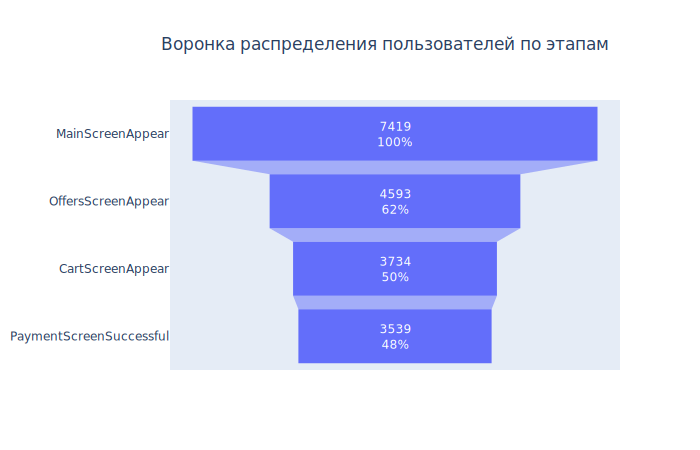

In [65]:
funnel(un_users(filt_df.query('event_name not in "Tutorial"')).reset_index(),  "Воронка распределения пользователей по этапам")

In [66]:
display(un_users(filt_df.query('event_name not in "Tutorial"'))\
        .assign(cr_total = lambda x: (x['count'] / filt_df['device_id_hash'].nunique()).map(formatter)))

,count,cr_initial,cr_prev,cr_total
event_name,,,,
MainScreenAppear,7419,100.0%,100.0%,98.5%
OffersScreenAppear,4593,61.9%,61.9%,61.0%
CartScreenAppear,3734,50.3%,81.3%,49.6%
PaymentScreenSuccessful,3539,47.7%,94.8%,47.0%


47% пользователей совершали 4 события хотя бы один раз. Больше всех пользователей теряется на этапе OffersScreenAppear - 38.1%, 47.7% пользователей, попавших на этап MainScreenAppear конвертировались в покупателей.

<a id='pay'></a>

### Вывод:

На этом этапе были проанализированы были построены воронки распределения записей по событиям и пользователям. Установлена последовательность событий:
- MainScreenAppear -> OffersScreenAppear -> CartScreenAppear -> PaymentScreenSuccessful

Так же было установлено, что событие Tutorial не расположено последовательно в воронке, этим шагом пользовалось небольшое число пользователей - 4.2% (0.4% записей в логах), поэтому, не будем учитывать его при построении воронки. 14% всех событий - успешная оплата, это 28.9% конверсии от общего числа событий. 47% всех пользователей совершали 4 события хотя бы один раз. Больше всех пользователей теряется на этапе OffersScreenAppear - 38.1%, 47.7% с этапа MainScreenAppear конвертируются в покупателей.

<a id='exp'></a>
## 5. Изучение результатов эксперимента

Ответим на вопрос, сколько пользователей в каждой экспериментальной группе?
<a id='us'></a>

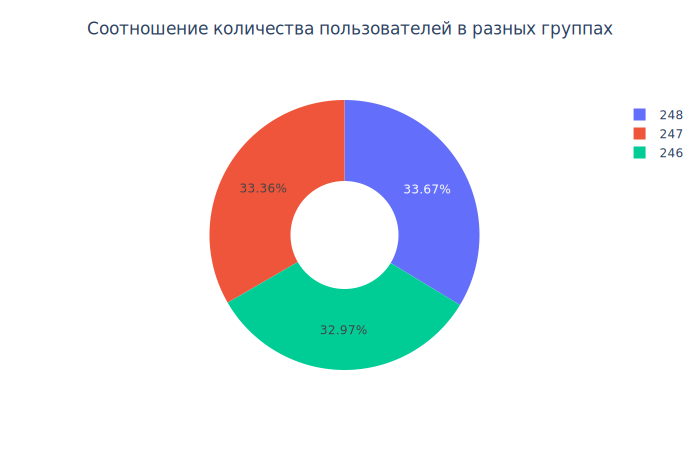

In [67]:
fig = go.Figure(data=[go.Pie(labels=groups.reset_index()['group'], values=groups['count'], 
                             text=groups['ratio'], textinfo='text',
                             hole=.4)])
fig.update_layout(
    title={
        'text': "Cоотношение количества пользователей в разных группах",
        'y':0.95,
        'x':0.5,})
fig.show()

Количество пользователей в трех группах различается в пределах 1%. При равном распределении пользователей по группам достигается оптимальная длительность теста, поэтому небольшие отклонения некритичны.

Есть 2 контрольные группы для А/А-эксперимента, чтобы проверить корректность всех механизмов и расчётов, проверим, находят ли статистические критерии разницу между выборками 246 и 247. Чтобы ответить на этот и другие вопросы, а также более наглядно представить данные по метрикам и долям, соберем таблицу по всем группам, а также рассчитаем конверсию к общему числу пользователей в каждой группе, чтобы определить разницу между долями на каждом этапе: 
<a id='cr'></a>

In [68]:
def guery_gen(num):
    query = filt_df.query('(exp_id == @num)')
    return query
users = un_users(guery_gen(246)).add_suffix('246')\
.join(un_users(guery_gen(247)).add_suffix('247'), on='event_name')\
.join(un_users(guery_gen(248)).add_suffix('248'), on='event_name')
users.index.name = None

In [69]:
for i in users.columns:
    for j in groups.index:
        if str(j) in i and 'count' in i:
            users['cr_all'+str(j)] = (users[i] / groups.loc[j]['count'])
            
users = users.assign(diff_246_247 = lambda x: ((x['cr_all246'] - x['cr_all247']).abs()).map(formatter),
                     diff_246_248 = lambda x: ((x['cr_all246'] - x['cr_all248']).abs()).map(formatter),
                     diff_247_248 = lambda x: ((x['cr_all247'] - x['cr_all248']).abs()).map(formatter))
for i in users.columns[users.columns.str.contains('all')]:
    users[i] = users[i].apply(formatter)

In [70]:
display(users)

,count246,cr_initial246,cr_prev246,count247,cr_initial247,cr_prev247,count248,cr_initial248,cr_prev248,cr_all246,cr_all247,cr_all248,diff_246_247,diff_246_248,diff_247_248
MainScreenAppear,2450,100.0%,100.0%,2476,100.0%,100.0%,2493,100.0%,100.0%,98.6%,98.5%,98.3%,0.1%,0.4%,0.3%
OffersScreenAppear,1542,62.9%,62.9%,1520,61.4%,61.4%,1531,61.4%,61.4%,62.1%,60.5%,60.3%,1.6%,1.7%,0.1%
CartScreenAppear,1266,51.7%,82.1%,1238,50.0%,81.4%,1230,49.3%,80.3%,51.0%,49.3%,48.5%,1.7%,2.5%,0.8%
PaymentScreenSuccessful,1200,49.0%,94.8%,1158,46.8%,93.5%,1181,47.4%,96.0%,48.3%,46.1%,46.6%,2.2%,1.8%,0.5%
Tutorial,278,11.3%,23.2%,283,11.4%,24.4%,279,11.2%,23.6%,11.2%,11.3%,11.0%,0.1%,0.2%,0.3%


Итоговая таблица получилось слишком большой и её сложно читать, будем извлекать выборочно столбцы для большей наглядности. 
Отфильтруем число пользователей на каждом этапе по группам, посчитаем долю пользователей, совершивших разные события:

In [71]:
def table_filt(df, string):
    return df[df.columns[df.columns.str.contains(string)]]

In [72]:
table_filt(users, 'count|initial')

,count246,cr_initial246,count247,cr_initial247,count248,cr_initial248
MainScreenAppear,2450,100.0%,2476,100.0%,2493,100.0%
OffersScreenAppear,1542,62.9%,1520,61.4%,1531,61.4%
CartScreenAppear,1266,51.7%,1238,50.0%,1230,49.3%
PaymentScreenSuccessful,1200,49.0%,1158,46.8%,1181,47.4%
Tutorial,278,11.3%,283,11.4%,279,11.2%


Больше всего пользователей с этапа MainScreenAppear переходят на этап OffersScreenAppear - от 61.4% до 62.9% в трех группах. Перешли на этап попкупки с этапа MainScreenAppear от 46.8% до 49% в трех группах.  

Отфильтруем конверсию от общего числа пользователей в каждой группе и различия по размеру группы на каждом этапе:

In [73]:
table_filt(users, 'all|diff_24')

,cr_all246,cr_all247,cr_all248,diff_246_247,diff_246_248,diff_247_248
MainScreenAppear,98.6%,98.5%,98.3%,0.1%,0.4%,0.3%
OffersScreenAppear,62.1%,60.5%,60.3%,1.6%,1.7%,0.1%
CartScreenAppear,51.0%,49.3%,48.5%,1.7%,2.5%,0.8%
PaymentScreenSuccessful,48.3%,46.1%,46.6%,2.2%,1.8%,0.5%
Tutorial,11.2%,11.3%,11.0%,0.1%,0.2%,0.3%


На этап MainScreenAppear попадают 98% пользователей, около 1.3-1.7% не попадают в воронку, вероятно остаются на этапе Tutorial. Переходят на этап OffersScreenAppear - от 61.4% до 62.9% в трех группах. Переходят на этап попкупки от 46.1% до 48.3% в трех группах. Разница между конверсиями в группах на каждом этапе колеблется в пределах от 0.1% до 2.5%.

Проверим, будет ли отличие между группами 246 и 247 статистически достоверным и ответим на вопрос, корректно ли работает разбиение на группы:
<a id='aa'></a>

Чтобы установить эквивалентность групп, напишем функцию для расчета статистической значимости между долями и определим нулевую и альтернативную гипотезу. 
- H(0) - нет значимых статистических различий между группами 246 и 247 на каждом этапе событий
- H(1) - есть значимые статистические различия между группами 246 и 247 для одного и более событий

Пороговое значение установим аlpha=0.05, но так как будем проводить множественный тест, будет расти вероятность получить ошибку первого рода, поэтому применим поправку Бонферрони и разделим alpha на число проверяемых гипотез (будем сравнивать группы A/A, A1/B, A2/B и A1A2/B, в каждой по 5 сравнений, суммарно 20). Alpha / 20 = 0.0025

In [74]:
alpha = 0.0025
def z_test(gr1,s1, gr2, s2):
    successes = np.array([s1, s2])
    trials = np.array([gr1, gr2])
    p1 = successes[0]/trials[0]
    p2 = successes[1]/trials[1]
    p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])
    difference = p1 - p2
    z_value = difference / np.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))
    distr = st.norm(0, 1)
    z_value = difference / np.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))
    distr = st.norm(0, 1) 
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    return p_value

In [75]:
users['aa_p-value'] = users.apply\
(lambda x: z_test(groups.loc[246]['count'], x['count246'], groups.loc[247]['count'], x['count247']).round(2), axis=1)
users['aa_difference'] = users['aa_p-value'].apply(lambda x: 'есть различия' if x < alpha else 'нет различий')

In [76]:
table_filt(users, 'aa')

,aa_p-value,aa_difference
MainScreenAppear,0.76,нет различий
OffersScreenAppear,0.25,нет различий
CartScreenAppear,0.23,нет различий
PaymentScreenSuccessful,0.11,нет различий
Tutorial,0.94,нет различий


На основе проведенного z-теста принимаем нулевую гипотезу, группы 246 и 247 эквивалентны, между ними нет значимых статистических различий. Разбиение на группы работает корректно.

Проверим, будет ли отличие между группами 246/248 (A1/B) и 247/248 (A2/B)  статистически достоверным и установим, влияет ли наличие новых шрифтов на поведение пользователей.

- H(0) - нет значимых статистических различий между группами 246 и 248, 247 и 248 на каждом этапе событий
- H(1) - есть значимые статистические различия между группами 246 и 248, 247 и 248 для одного и более событий

In [77]:
users['a1b_p-value'] = users.apply\
(lambda x: z_test(groups.loc[246]['count'], x['count246'], groups.loc[248]['count'], x['count248']).round(2), axis=1)
users['a1b_difference'] = users['a1b_p-value'].apply(lambda x: 'есть различия' if x < alpha else 'нет различий')
table_filt(users, 'a1b')

,a1b_p-value,a1b_difference
MainScreenAppear,0.29,нет различий
OffersScreenAppear,0.21,нет различий
CartScreenAppear,0.08,нет различий
PaymentScreenSuccessful,0.21,нет различий
Tutorial,0.83,нет различий


In [78]:
users['a2b_p-value'] = users.apply\
(lambda x: z_test(groups.loc[247]['count'], x['count247'], groups.loc[248]['count'], x['count248']).round(2), axis=1)
users['a2b_difference'] = users['a2b_p-value'].apply(lambda x: 'есть различия' if x < alpha else 'нет различий')
table_filt(users, 'a2b')

,a2b_p-value,a2b_difference
MainScreenAppear,0.46,нет различий
OffersScreenAppear,0.92,нет различий
CartScreenAppear,0.58,нет различий
PaymentScreenSuccessful,0.74,нет различий
Tutorial,0.77,нет различий


По результатам тестов между группами 246 и 248, 247 и 248 нет значимых статистических различий на каждом этапе. Принимаем нулевую гипотезу, изменение шрифтов не влияет на поведение пользователей при сравнении контрольных групп с экспериментальной.

Поскольку 246 и 247 группы эквивалентны между собой, проделаем такое же сравнение для объдиненных групп A с группой B и посмотрим, есть ли статистические различия. Сформируем нулевую и альтернативные гипотезы:
- H(0) - нет значимых статистических различий между группами A и B на каждом этапе событий
- H(1) - есть значимые статистические различия между группами A и B для одного и более событий

Присоединим объединенную группу в таблицу users и проведем z-тест:
<a id='ab'></a>

In [79]:
ab_groups = filt_df.groupby('groups').agg({'device_id_hash':'nunique'}).rename(columns={'device_id_hash':'count'})
users = users.join(un_users(filt_df.query('groups == "A"')).add_suffix('_united'))

In [80]:
table_filt(users, 'united')

,count_united,cr_initial_united,cr_prev_united
MainScreenAppear,4926,100.0%,100.0%
OffersScreenAppear,3062,62.2%,62.2%
CartScreenAppear,2504,50.8%,81.8%
PaymentScreenSuccessful,2358,47.9%,94.2%
Tutorial,561,11.4%,23.8%


In [81]:
users['aab_p-value'] = users.apply\
(lambda x: z_test(ab_groups.loc['A']['count'], x['count_united'], ab_groups.loc['B']['count'], x['count248'])\
 .round(2), axis=1)
users['aab_difference'] = users['aab_p-value'].apply(lambda x: 'есть различия' if x < alpha else 'нет различий')

In [82]:
table_filt(users, 'aab')

,aab_p-value,aab_difference
MainScreenAppear,0.29,нет различий
OffersScreenAppear,0.43,нет различий
CartScreenAppear,0.18,нет различий
PaymentScreenSuccessful,0.60,нет различий
Tutorial,0.76,нет различий


Таким образом, по результатам z-теста принимаем нулевую гипотезу. Можно сделать вывод о том, что нет значимых статистических различий между группами A и B на каждом этапе, изменение шрифтов не влияет на поведение пользователей.

### Вывод:

На этом этапе было установлено:
- Количество пользователей в трех группах различается различается в пределах 1%.
- На этап MainScreenAppear попадают 98% пользователей, около 1.3-1.7% не попадают в воронку, вероятно остаются на этапе Tutorial.
- Переходят на этап OffersScreenAppear - от 61.4% до 62.9% в трех группах. 
- Переходят на этап попкупки от 46.1% до 48.3% в трех группах. Разница между конверсиями в группах на каждом этапе колеблется в пределах от 0.1% до 2.5%.
- Перешли на этап попкупки с этапа MainScreenAppear от 46.8% до 49% в трех группах.
- Между группами 246 и 247 нет значимых статистических различий по результатам z-теста, они эквивалентны, разбиение на группы работает корректно.
- Между группами 246 и 248, 247 и 248 нет значимых статистических различий по результатам z-теста на каждом этапе воронки, изменение шрифтов не влияет на поведение пользователей
- Между группами A (246 и 247) и B (248) нет значимых статистических различий по результатам z-теста на каждом этапе воронки, они эквивалентны, изменение шрифтов не влияет на поведение пользователей.

<a id='result'></a>
## Общий вывод:

Были изучены данные о логах событий магазина продуктов питания, построена и изучена воронка продаж, исследованы результаты A/B теста. Были получены следующие выводы:
- число событий в логе: 243713 
- число уникальных пользователей в логе: 7551
- среднее число событий на пользователя: 32
- также определили, что располагаем данными за период с 1-го по 7е августа. Данные отфильтровали, было отброшено 1.2% значений датасета, 17 уникальных пользователей. После фильтрации количество пользователей в трех группах различается в пределах 1%.
- установлена последовательность событий: MainScreenAppear -> OffersScreenAppear -> CartScreenAppear -> PaymentScreenSuccessful. Cобытие Tutorial не расположено последовательно в воронке, этим шагом пользовалось небольшое число пользователей - 4.2% (0.4% записей в логах)
- 14% всех событий - успешная оплата, это 28.9% конверсии от общего числа событий
- 47% всех пользователей совершали 4 события хотя бы один раз
- Больше всех пользователей теряется на этапе OffersScreenAppear - 38.1%
- 47.7% конвертируются в покупателей
- На этап MainScreenAppear попадают 98% пользователей из трех групп, около 1.3-1.7% не попадают в воронку, вероятно остаются на этапе Tutorial
- Переходят на этап попкупки от 46.1% до 48.3% в трех группах. Разница между конверсиями в группах на каждом этапе колеблется в пределах от 0.1% до 2.5%
- Между группами 246 и 247 нет значимых статистических различий по результатам z-теста, они эквивалентны, разбиение на группы работает корректно
- Между группами 246 и 248, 247 и 248 нет значимых статистических различий по результатам z-теста на каждом этапе воронки, изменение шрифтов не влияет на поведение пользователей
- Между группами A (246 и 247) и B (248) нет значимых статистических различий по результатам z-теста на каждом этапе воронки, они эквивалентны, изменение шрифтов не влияет на поведение пользователей